### Time to get your hands dirty. SDSS Galaxies vs quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey. 

This is one of the most famous example of machine-learning classification in astronomy. For some recent work see e.g. 
- *Identifying galaxies, quasars, and stars with machine learning: A new catalogue of classifications for 111 million SDSS sources without spectra* Clarke et al (2019) [arXiv:1909.10963](https://arxiv.org/abs/1909.10963)
- *Quasar and galaxy classification in Gaia Data Release 2* Bailer-Jones et al (2019) [arXiv:1910.05255](https://arxiv.org/abs/1910.05255)

Some figures from the second paper:

#### Data

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it myself from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors)

(If you've never used [SQL](https://en.wikipedia.org/wiki/SQL) and want to learn something new in computing, it's very powerful)

#### Tasks

- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

#### Ideas
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?

In [34]:
import numpy as np
import pylab as plt

data = np.genfromtxt('galaxyquasar.csv', delimiter=',',names=True,usecols=(0,1,2,3,4,6),dtype=float,comments='#')
names = data.dtype.names
names

('u', 'g', 'r', 'i', 'z', 'z1')

In [35]:
# Extracting the relevant columns from the data 
u_g = data['u'] - data['g']
g_r = data['g'] - data['r']
r_i = data['r'] - data['i']
i_z = data['i'] - data['z']

In [36]:
classi = np.genfromtxt('galaxyquasar.csv', delimiter=',',skip_header=1,usecols=5,dtype=str)
classi

array(['QSO', 'GALAXY', 'GALAXY', ..., 'GALAXY', 'GALAXY', 'GALAXY'],
      dtype='<U6')

In [37]:
# Convert string labels to numeric: GALAXY → 0, QSO → 1
QuasGal = np.where(classi == 'GALAXY', 0, 1)

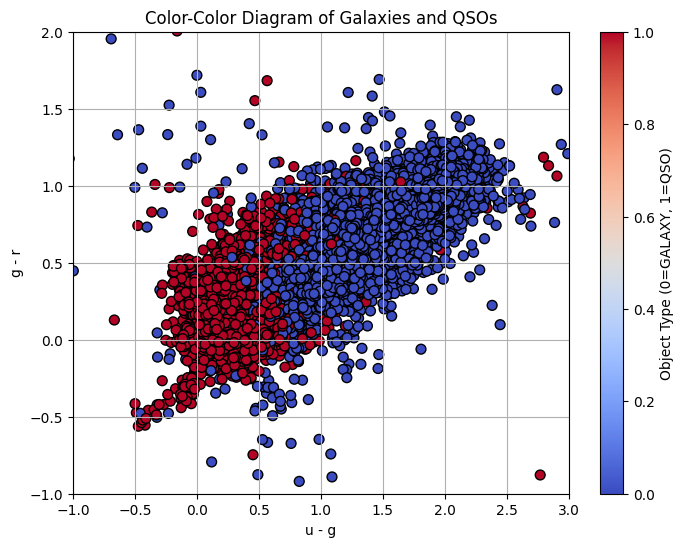

In [38]:
# Plotting the color-color diagram
plt.figure(figsize=(8, 6))
plt.scatter(u_g, g_r, c=QuasGal, cmap='coolwarm', edgecolor='k', s=50)
plt.colorbar(label='Object Type (0=GALAXY, 1=QSO)')

plt.xlabel('u - g')
plt.ylabel('g - r')
plt.title('Color-Color Diagram of Galaxies and QSOs')
plt.grid(True)
plt.xlim(-1, 3) #we need this to focus on the interest region
plt.ylim(-1, 2)
plt.show()

#this could be a bimodality, but it is not clear, and also thers the possibility that the other color show the bimodality too
# change of approach: make a corner plot

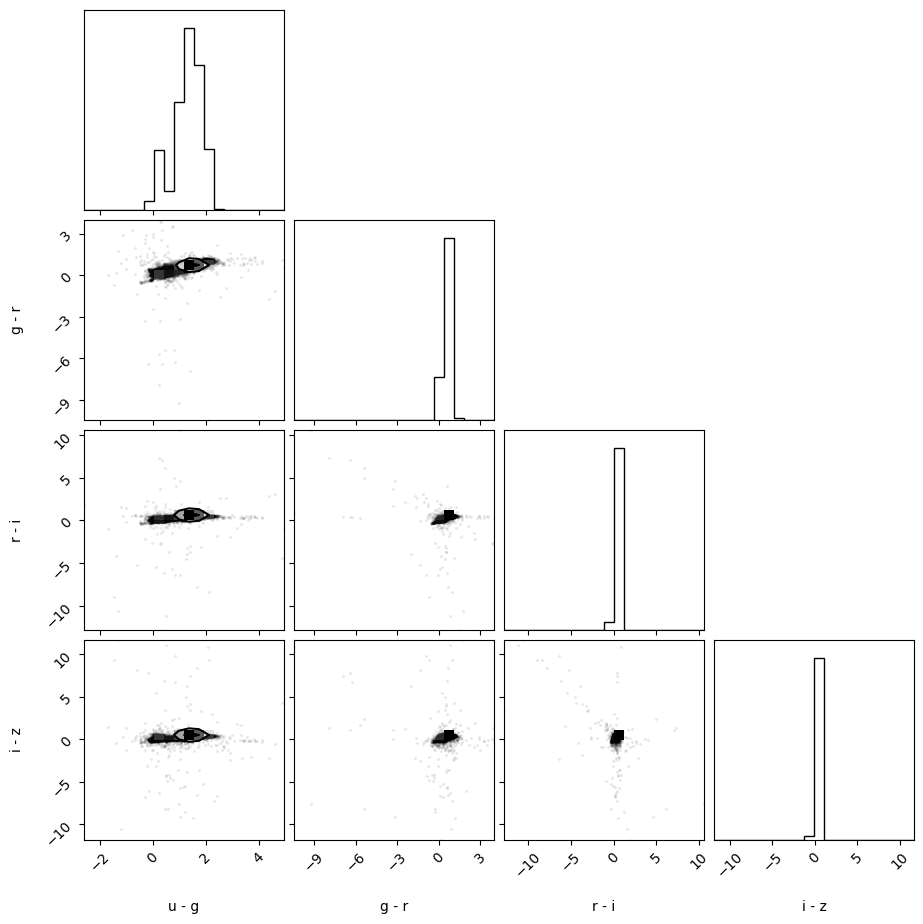

In [39]:
import corner
corner.corner(np.array([u_g, g_r, r_i, i_z]).T, labels=['u - g', 'g - r', 'r - i', 'i - z']);
#without the ";" it print two times the corner plot... 

In [40]:
# only the u-g vs g-r plot shows a bimodality

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

x = np.column_stack((u_g, g_r, r_i, i_z)) #that has shape (N, 4) as sklearn expects
y = QuasGal

x_train, x_test, y_train, y_test = tts(x, y, test_size=0.5, random_state=42)

# **GAUSSIAN NAIVE BAYES**

/tmp/ipykernel_36236/855929812.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)
/tmp/ipykernel_36236/855929812.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)
/tmp/ipykernel_36236/855929812.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)
/tmp/ipykernel_36236/855929812.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)


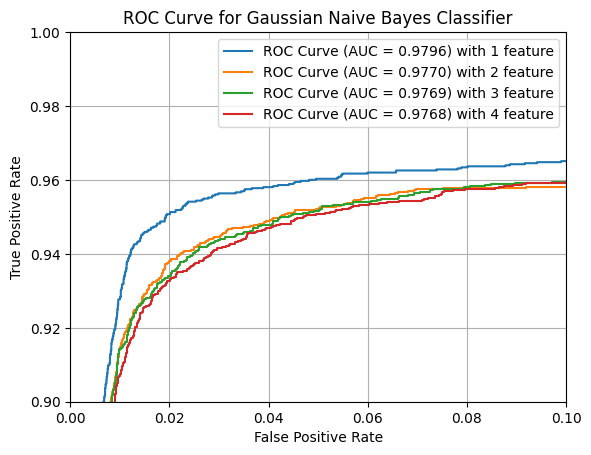

In [41]:
# Evaluation of the model with a ROC curve

from sklearn.naive_bayes import GaussianNB

best_auc = 0
best_model = None

for i in range(4):  # Test with 1 to 4 features
    X_train_i = x_train[:, :i+1]
    X_test_i = x_test[:, :i+1]
    gnb_i = GaussianNB()
    gnb_i.fit(X_train_i, y_train)
    y_pred = gnb_i.predict_proba(X_test_i)[:, 1] #Predict proba gives a value between 1 and 0 , in a matrix, with [:,1] we take the second column, which is the probability of being a QSO
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = np.trapz(tpr, fpr)
    plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.4f}) with {} feature'.format(auc, i+1))

    if auc > best_auc:
        best_auc = auc
        best_model = gnb_i

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gaussian Naive Bayes Classifier')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.1)
plt.ylim(0.9, 1)
plt.show()

In [42]:
# Plotting the decision boundary  ----------------- this part is usefull to draw the region

xx, yy = np.meshgrid(np.linspace(-1, 3, 300),
                     np.linspace(-1, 2, 300))

# Build input grid using only u-g and g-r
grid_input = np.column_stack([
    xx.ravel(),  # u-g
    yy.ravel()   # g-r
])
#-------------------------------------------------------

x_train_2D = x_train[:, :2]
x_test_2D = x_test[:, :2]

/tmp/ipykernel_36236/4190352181.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


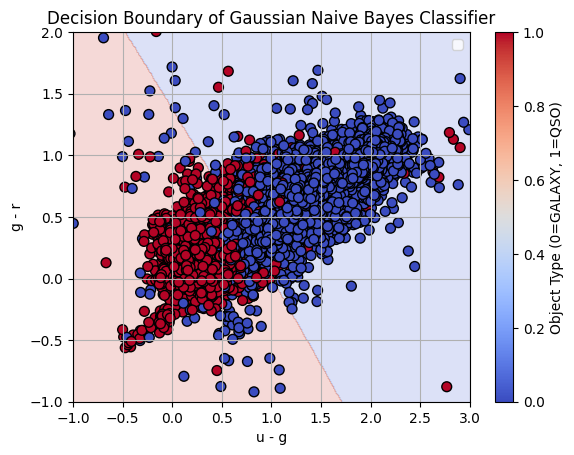

In [43]:
gnb_i.fit(x_train_2D, y_train) #plot the best with for features

Z = gnb_i.predict(grid_input).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap='coolwarm')

plt.scatter(u_g, g_r, c=QuasGal, cmap='coolwarm', edgecolor='k', s=50)
plt.colorbar(label='Object Type (0=GALAXY, 1=QSO)')

plt.xlabel('u - g')
plt.ylabel('g - r')
plt.title('Decision Boundary of Gaussian Naive Bayes Classifier')
plt.grid(True)
plt.legend()
plt.xlim(-1, 3)
plt.ylim(-1, 2)
plt.show()

In [44]:
y_pred_final = gnb_i.predict(x_test_2D)  

cm = confusion_matrix(y_test, y_pred_final)

print("Confusion Matrix:\n", cm)
print("\n Accuracy for this model:", accuracy_score(y_test, y_pred_final))

Confusion Matrix:
 [[21102   345]
 [  243  3310]]

 Accuracy for this model: 0.97648


# **LDA & QDA**

/tmp/ipykernel_36236/1168698264.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr_lda, fpr_lda)
/tmp/ipykernel_36236/1168698264.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr_lda, fpr_lda)
/tmp/ipykernel_36236/1168698264.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr_lda, fpr_lda)
/tmp/ipykernel_36236/1168698264.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr_lda, fpr_lda)


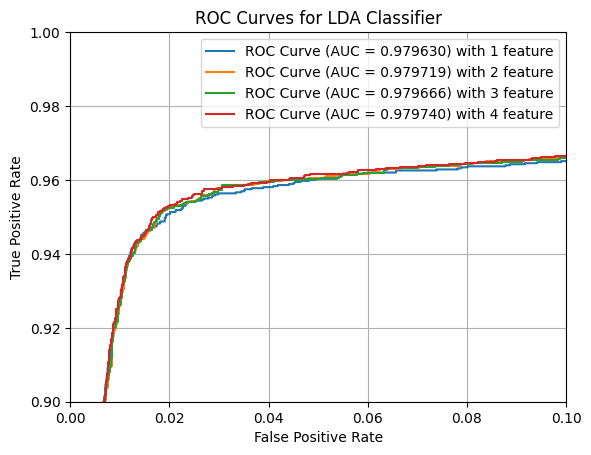

/tmp/ipykernel_36236/1168698264.py:49: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr_qda, fpr_qda)
/tmp/ipykernel_36236/1168698264.py:49: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr_qda, fpr_qda)
/tmp/ipykernel_36236/1168698264.py:49: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr_qda, fpr_qda)
/tmp/ipykernel_36236/1168698264.py:49: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr_qda, fpr_qda)


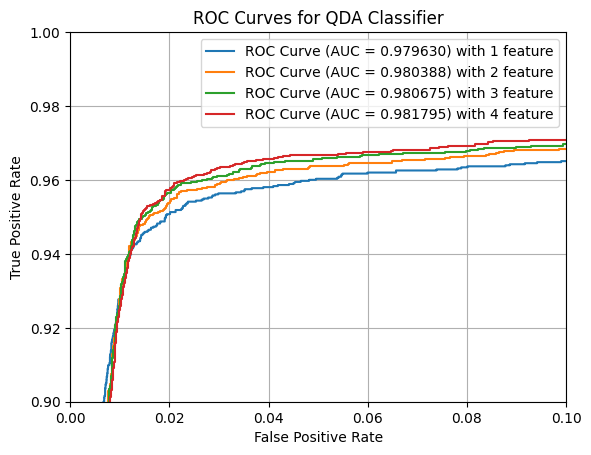

In [ ]:
# analyzing the results of LDA and QDA with ROC curves

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

best_auc = 0
best_model_lda = None

for i in range(4):  # Test with 1 to 4 features
    X_train_i = x_train[:, :i+1]
    X_test_i = x_test[:, :i+1]

    lda = LDA()

    lda.fit(X_train_i, y_train)

    y_pred_lda_proba = lda.predict_proba(X_test_i)[:, 1] 
    fpr_lda, tpr_lda, thresholds_lda = roc_curve(y_test, y_pred_lda_proba)
    auc = np.trapz(tpr_lda, fpr_lda)

    plt.plot(fpr_lda, tpr_lda, label='ROC Curve (AUC = {:.6f}) with {} feature'.format(auc, i+1))

    if auc > best_auc:
        best_auc = auc
        best_model_lda = lda

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for LDA Classifier')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.1)
plt.ylim(0.9, 1)
plt.show()

best_auc = 0
best_model_qda = None

for i in range(4):  # Test with 1 to 4 features
    X_train_i = x_train[:, :i+1]
    X_test_i = x_test[:, :i+1]

    qda = QDA()

    qda.fit(X_train_i, y_train)

    y_pred_qda_proba = qda.predict_proba(X_test_i)[:, 1]
    fpr_qda, tpr_qda, thresholds_qda = roc_curve(y_test, y_pred_qda_proba)
    auc = np.trapz(tpr_qda, fpr_qda)
    plt.plot(fpr_qda, tpr_qda, label='ROC Curve (AUC = {:.6f}) with {} feature'.format(auc, i+1))

    if auc > best_auc:
        best_auc = auc
        best_model_qda = qda
        
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for QDA Classifier')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.1)
plt.ylim(0.9, 1)
plt.show()

/tmp/ipykernel_36236/3376837636.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


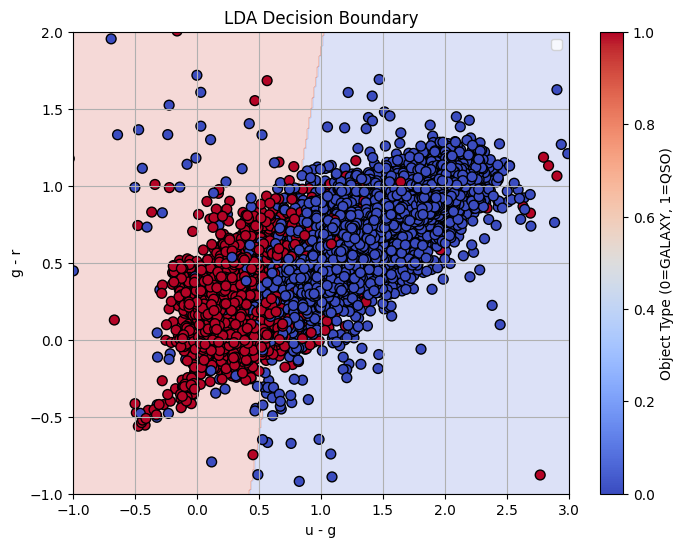

/tmp/ipykernel_36236/3376837636.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


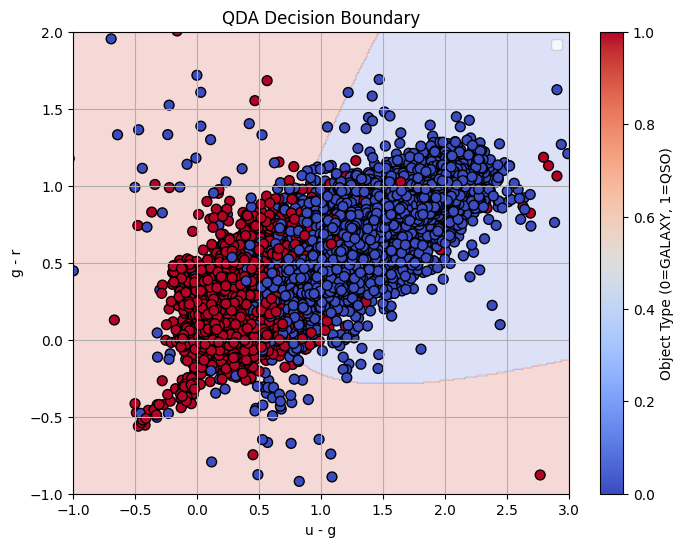

In [46]:
best_model_lda.fit(x_train_2D, y_train)
best_model_qda.fit(x_train_2D, y_train)


# Plotting the decision boundary for LDA
Z_lda = best_model_lda.predict(grid_input).reshape(xx.shape)
# Plotting the decision boundary for QDA
Z_qda = best_model_qda.predict(grid_input).reshape(xx.shape)


plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_lda, alpha=0.2, cmap='coolwarm')
plt.scatter(u_g, g_r, c=QuasGal, cmap='coolwarm', edgecolor='k', s=50)
plt.colorbar(label='Object Type (0=GALAXY, 1=QSO)')
plt.xlabel('u - g')
plt.ylabel('g - r')
plt.title('LDA Decision Boundary')              
plt.grid(True)
plt.legend()
plt.xlim(-1, 3)
plt.ylim(-1, 2)
plt.show()

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_qda, alpha=0.2, cmap='coolwarm')
plt.scatter(u_g, g_r, c=QuasGal, cmap='coolwarm', edgecolor='k', s=50)
plt.colorbar(label='Object Type (0=GALAXY, 1=QSO)')
plt.xlabel('u - g')
plt.ylabel('g - r')
plt.title('QDA Decision Boundary')
plt.grid(True)
plt.legend()
plt.xlim(-1, 3)
plt.ylim(-1, 2)
plt.show()

In [47]:
y_pred_final = best_model_lda.predict(x_test_2D)  

cm = confusion_matrix(y_test, y_pred_final)

print("Confusion Matrix:\n", cm)
print("\n Accuracy for this model:", accuracy_score(y_test, y_pred_final))


Confusion Matrix:
 [[21225   222]
 [  256  3297]]

 Accuracy for this model: 0.98088


In [48]:
y_pred_final = best_model_qda.predict(x_test_2D)  

cm = confusion_matrix(y_test, y_pred_final)

print("Confusion Matrix:\n", cm)
print("\n Accuracy for this model:", accuracy_score(y_test, y_pred_final))

Confusion Matrix:
 [[21222   225]
 [  238  3315]]

 Accuracy for this model: 0.98148


# **GMM BAYES**

/tmp/ipykernel_36236/990942918.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)
/tmp/ipykernel_36236/990942918.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)
/tmp/ipykernel_36236/990942918.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)
/tmp/ipykernel_36236/990942918.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)


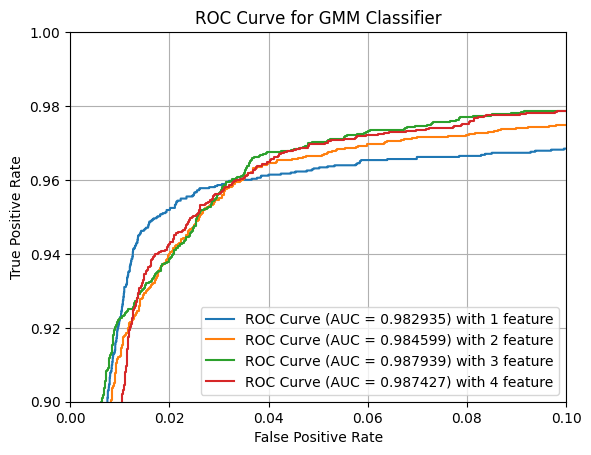

In [54]:
from astroML.classification import GMMBayes

best_auc = 0
best_model = None

for i in range(4):  # Test with 1 to 4 features
    X_train_i = x_train[:, :i+1]
    X_test_i = x_test[:, :i+1]
    gmm = GMMBayes(n_components=2)
    gmm.fit(X_train_i, y_train)

    y_pred_gmm_proba = gmm.predict_proba(X_test_i)[:, 1]
    fpr, tpr, thresholds_gmm = roc_curve(y_test, y_pred_gmm_proba)
    auc = np.trapz(tpr, fpr)
    plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.6f}) with {} feature'.format(auc, i+1))

    if auc > best_auc:
        best_auc = auc
        best_model = gmm


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GMM Classifier')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.1)
plt.ylim(0.9, 1)
plt.show()

/tmp/ipykernel_36236/4047141911.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


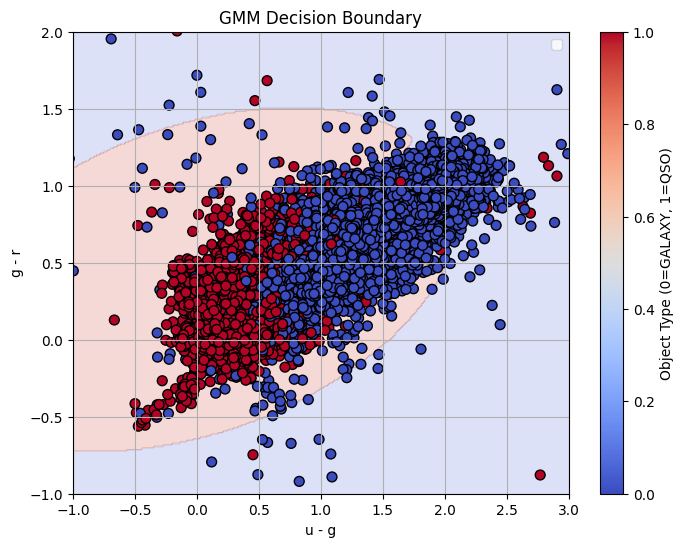

In [55]:
best_model.fit(x_train_2D, y_train)

Z_gmm = best_model.predict(grid_input).reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_gmm, alpha=0.2, cmap='coolwarm')
plt.scatter(u_g, g_r, c=QuasGal, cmap='coolwarm', edgecolor='k', s=50)
plt.colorbar(label='Object Type (0=GALAXY, 1=QSO)')
plt.xlabel('u - g')
plt.ylabel('g - r')
plt.title('GMM Decision Boundary')
plt.grid(True)
plt.legend()
plt.xlim(-1, 3)
plt.ylim(-1, 2)
plt.show()

In [57]:
y_pred_final = best_model.predict(x_test_2D)  

cm = confusion_matrix(y_test, y_pred_final)

print("Confusion Matrix:\n", cm)
print("\n Accuracy for this model:", accuracy_score(y_test, y_pred_final))

Confusion Matrix:
 [[21149   298]
 [  265  3288]]

 Accuracy for this model: 0.97748


# **K Neighbors**

/tmp/ipykernel_36236/266811972.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)
/tmp/ipykernel_36236/266811972.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)
/tmp/ipykernel_36236/266811972.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)
/tmp/ipykernel_36236/266811972.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)
/tmp/ipykernel_36236/266811972.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, 

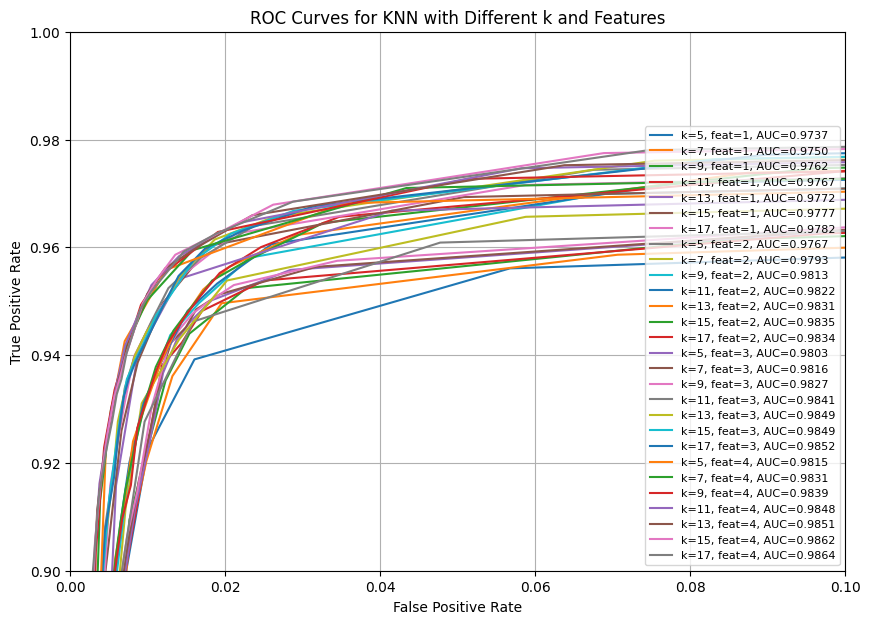

 Best KNN model: k=17, features=4, AUC=0.9864


In [64]:
from sklearn.neighbors import KNeighborsClassifier

max_features = x_train.shape[1]
k_values = [5, 7, 9, 11, 13, 15 ,17]  #number of neighbours

best_auc = 0
best_model = None
best_config = None

plt.figure(figsize=(10, 7))

for n_feat in range(1, max_features + 1):
    X_train_i = x_train[:, :n_feat]
    X_test_i = x_test[:, :n_feat]
    
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_i, y_train)
        y_pred_proba = knn.predict_proba(X_test_i)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = np.trapz(tpr, fpr)
        
        plt.plot(fpr, tpr, label=f'k={k}, feat={n_feat}, AUC={auc:.4f}')
        
        if auc > best_auc:
            best_auc = auc
            best_model = knn
            best_config = (k, n_feat)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for KNN with Different k and Features')
plt.legend(loc='lower right', fontsize=8)
plt.grid(True)
plt.xlim(0, 0.1)
plt.ylim(0.9, 1)
plt.show()

print(f" Best KNN model: k={best_config[0]}, features={best_config[1]}, AUC={best_auc:.4f}")


/tmp/ipykernel_36236/1692738001.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


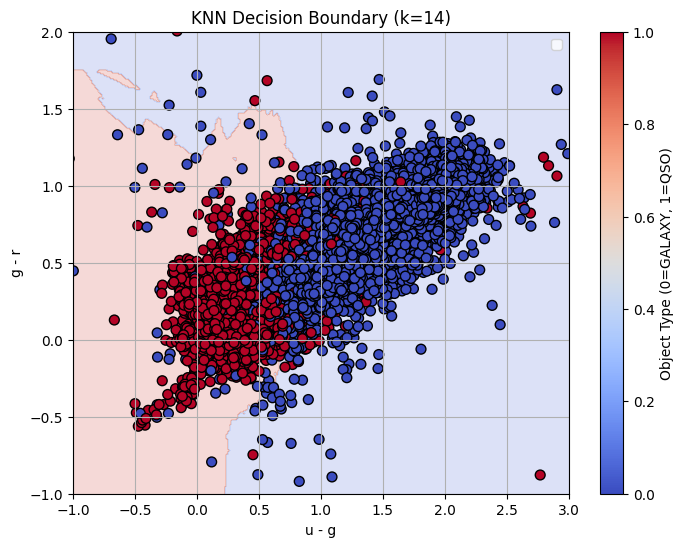

In [65]:
best_model.fit(x_train_2D, y_train)
Z_knn = best_model.predict(grid_input).reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_knn, alpha=0.2, cmap='coolwarm')
plt.scatter(u_g, g_r, c=QuasGal, cmap='coolwarm', edgecolor='k', s=50)
plt.colorbar(label='Object Type (0=GALAXY, 1=QSO)')
plt.xlabel('u - g')
plt.ylabel('g - r')
plt.title(f'KNN Decision Boundary (k={n})')
plt.grid(True)
plt.legend()
plt.xlim(-1, 3)
plt.ylim(-1, 2)
plt.show()


In [66]:
y_pred_final = best_model.predict(x_test_2D)  

cm = confusion_matrix(y_test, y_pred_final)

print("Confusion Matrix:\n", cm)
print("\n Accuracy for this model:", accuracy_score(y_test, y_pred_final))

Confusion Matrix:
 [[21239   208]
 [  245  3308]]

 Accuracy for this model: 0.98188
